データサイエンス特別PG データサイエンス特論 第13回 主成分分析

In [1]:
# google colab で実行する場合は下記のコメントアウトを外して実行する
# ! wget https://raw.githubusercontent.com/KHiraGit/sudspg_ds/main/ic_103_decathlon.csv

# 下記を参考に作成
# https://santakalog.com/2021/02/13/python-pca/

In [21]:
# ライブラリをインポート
import os
import psutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans


In [22]:
# 論理コア（logical cores）の数を取得し、環境変数に設定
# https://relaxing-living-life.com/1831/
def set_loky_max_cpu_count():
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    cpu_count = max(1, min(physical_cores, logical_cores))
    os.environ['LOKY_MAX_CPU_COUNT'] = str(cpu_count)
    print(f"LOKY_MAX_CPU_COUNT set to {cpu_count}")
set_loky_max_cpu_count()

LOKY_MAX_CPU_COUNT set to 20


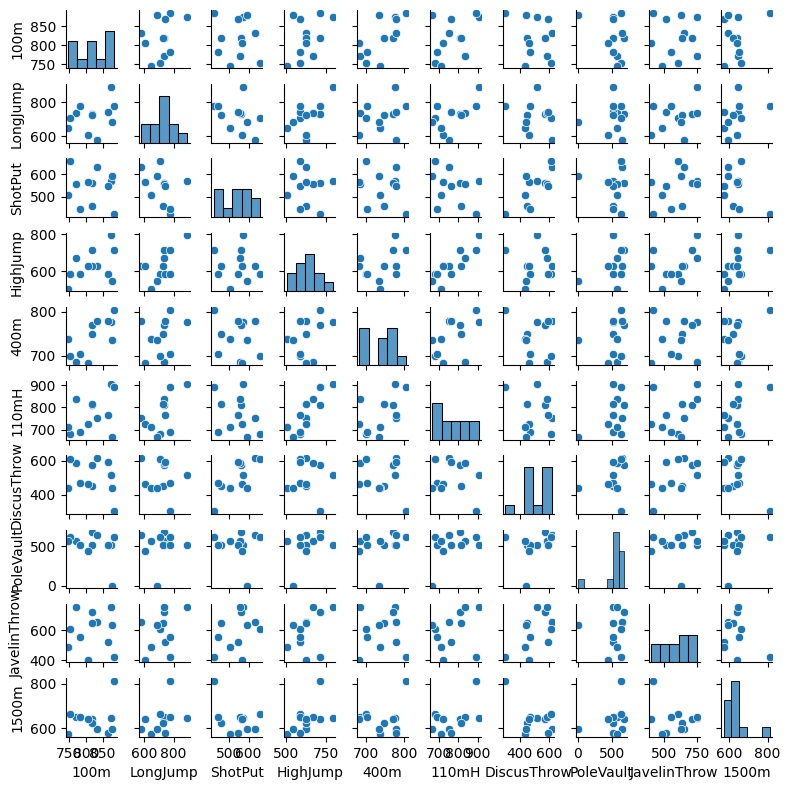

In [3]:
# 十種競技のデータ(csv形式)を読み込んでデータフレームを作成
decathlon_df = pd.read_csv('ic_103_decathlon.csv', encoding='utf-8') # 棒高跳びで記録なしの選手は、外れ値とみなして得点をかさ上げした
# ペアプロットを表示 (順位の列は除外)
sns.pairplot(decathlon_df.drop(columns='Rank'), height=0.8, aspect=1)

In [4]:
decathlon_df.head()

,Rank,100m,LongJump,ShotPut,HighJump,400m,110mH,DiscusThrow,PoleVault,JavelinThrow,1500m
0,1,874,893,571,794,776,906,514,509,753,645
1,2,819,732,559,714,771,810,572,673,717,641
2,3,771,736,557,670,686,836,584,562,752,649
3,4,832,576,631,627,779,751,615,645,655,596
4,5,885,776,423,714,805,890,303,617,421,813


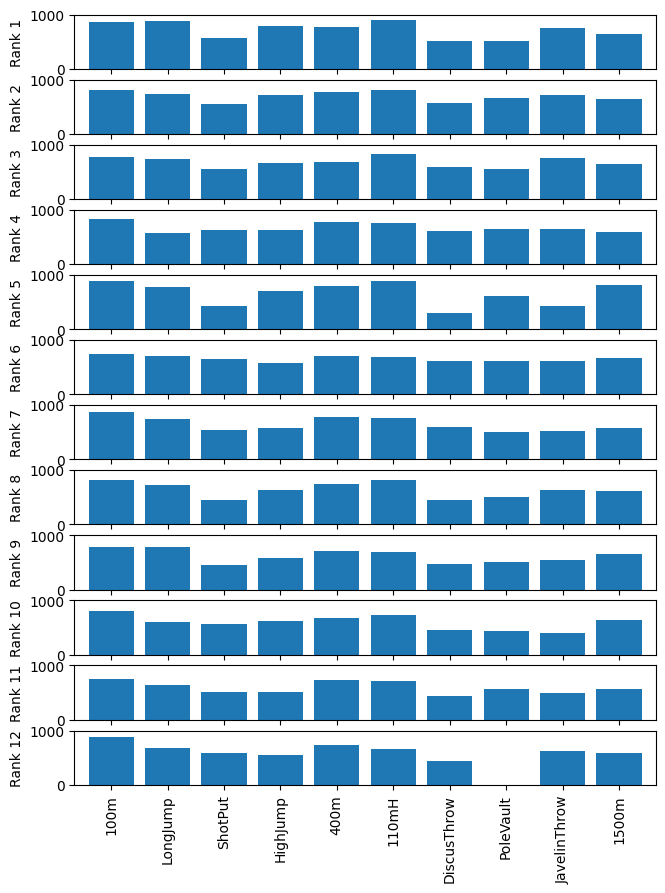

In [5]:
# 線種の成績を棒グラフで表示
f, axes = plt.subplots(len(decathlon_df), 1, sharex=True, figsize=(7.5,10))
for i, ax in enumerate(axes):
    decathlon_df.iloc[i, 1:].plot(ax=ax, kind='bar', width=0.8)
    ax.set_ylabel(f'Rank {i+1}')
    ax.set_ylim(0, 1000)

In [6]:
decathlon_df.index.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

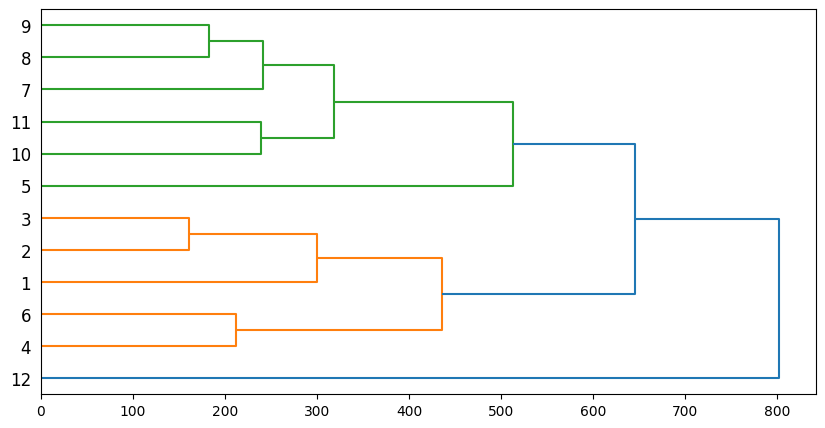

In [7]:
# クラスター間の距離を計算 (ユークリッド距離を利用)
dist = hierarchy.distance.pdist(decathlon_df.drop(columns='Rank'), metric='euclidean')
# クラスターを統合 (ward法)
linkage = hierarchy.linkage(dist, method='ward', metric='euclidean') 
# デンドログラムを表示
fig, ax = plt.subplots(figsize=(10,5))
ax = hierarchy.dendrogram(Z=linkage, orientation='right', labels=decathlon_df['Rank'].tolist())

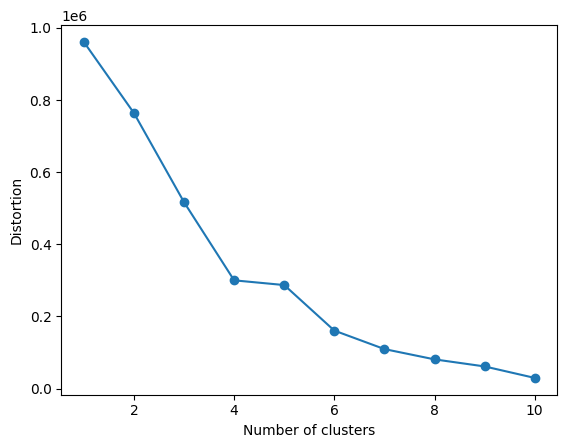

In [23]:
distortions = []

for i  in range(1,11):
    km = KMeans(n_clusters=i, n_init='auto', max_iter=30)
    km.fit(decathlon_df.drop(columns='Rank'))
    distortions.append(km.inertia_)

# plt.figure(figsize=(10,4))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

rank_1: cluster:0
rank_2: cluster:0
rank_3: cluster:0
rank_4: cluster:0
rank_5: cluster:1
rank_6: cluster:0
rank_7: cluster:1
rank_8: cluster:1
rank_9: cluster:1
rank_10: cluster:1
rank_11: cluster:1
rank_12: cluster:2


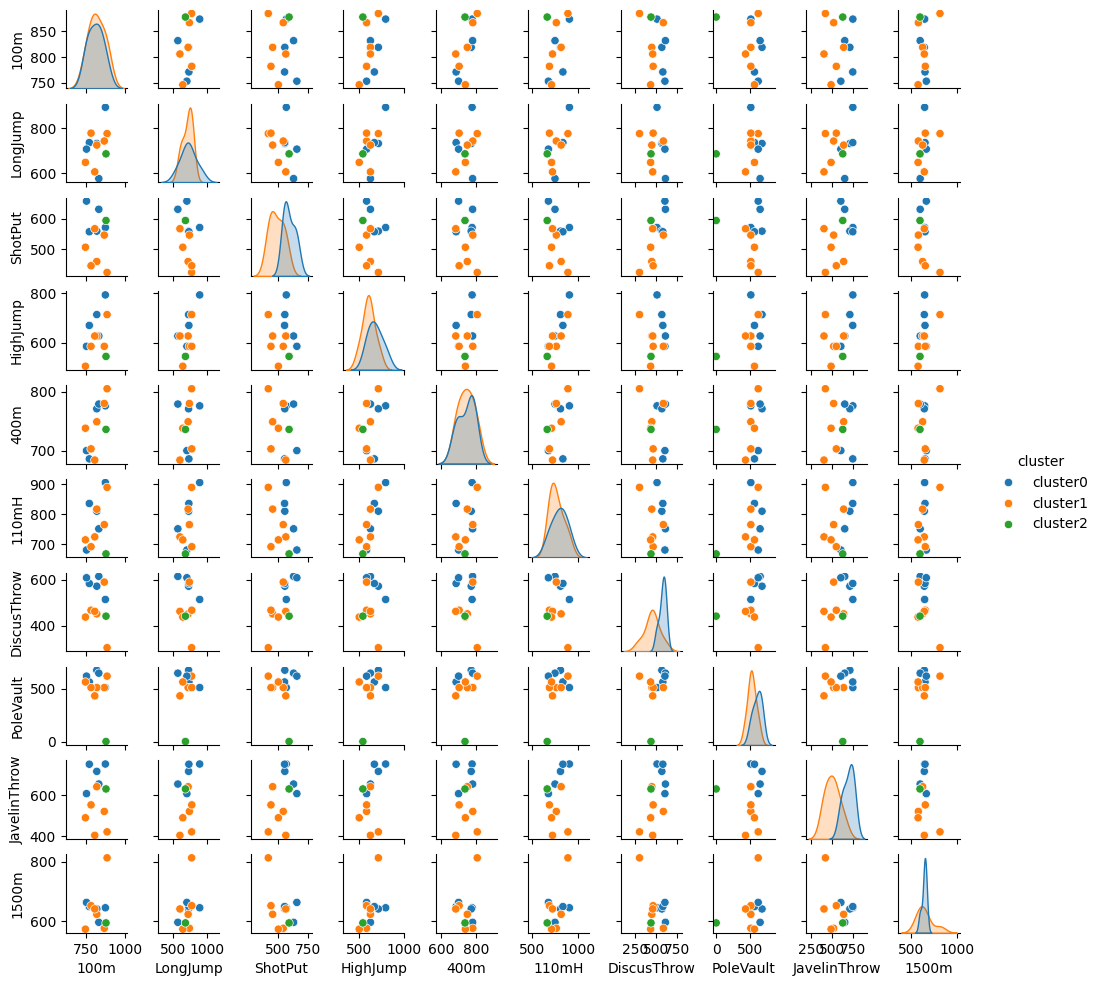

In [9]:
# kmeans法を実行
kmeans = KMeans(n_clusters=3, n_init='auto', max_iter=30, init="random")
cluster = kmeans.fit_predict(decathlon_df.drop(columns='Rank'))
# 結果を確認
decathlon_df_result = decathlon_df.drop(columns='Rank').copy()
decathlon_df_result["cluster"] = ["cluster"+str(x) for x in cluster]
sns.pairplot(decathlon_df_result, hue='cluster', height=1.0)
for i, x in enumerate(cluster):
    print(f'rank_{i+1}: cluster:{x}')

In [10]:
decathlon_df = pd.read_csv('ic_103_decathlon.csv', encoding='utf-8') # 棒高跳びで記録なしの選手は、外れ値とみなして得点をかさ上げした
# データを標準化
data = ['100m', 'LongJump', 'ShotPut', 'HighJump', '400m', 
        '110mH', 'DiscusThrow', 'PoleVault', 'JavelinThrow', '1500m']
stdsc = StandardScaler()
decathlon_std_df = stdsc.fit_transform(decathlon_df[data])

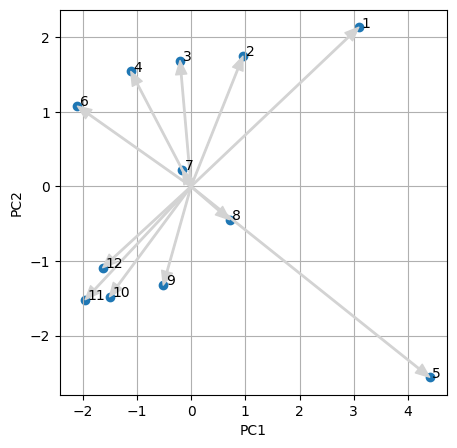

In [11]:
#主成分分析を実行
pca = PCA()
pca.fit(decathlon_std_df)

# データを主成分空間に写像
pca_cor = pca.transform(decathlon_std_df)
pca_df = pd.DataFrame(pca_cor, columns = data)

# 第一主成分と第二主成分で各選手の成績をプロット
plt.figure(figsize=(5, 5))
origin =(0,0)
for x, y, name in zip(pca_cor[:, 0], pca_cor[:, 1], decathlon_df['Rank']):
    plt.annotate(text='', xy=(x,y), xytext=origin, # text='' でエラーとなる場合は s='' に変更する
                 arrowprops=dict(shrink=0, width=1, headwidth=8, headlength=10, 
                 connectionstyle='arc3', facecolor='lightgray', edgecolor='lightgray'))
    plt.text(x+0.05, y, name)
plt.scatter(pca_cor[:, 0], pca_cor[:, 1])
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [12]:
# 主成分分析の結果を確認 主成分得点
score = pd.DataFrame(pca.transform(decathlon_std_df), index=decathlon_df.index)
# score.to_excel('ic_103_decathlon_pca_res.xlsx', index=True, header=True)
score

,0,1,2,3,4,5,6,7,8,9
0,3.093550,2.136453,-0.960444,-0.902419,-0.044775,0.169444,-0.398939,0.552445,0.191999,0.043089
1,0.957457,1.747467,0.369027,0.479034,-0.183427,-0.126853,0.280027,-0.137499,0.379978,-0.109148
2,-0.202831,1.689241,1.193376,-1.334165,0.218733,-0.694148,-0.060410,-0.233001,-0.484083,-0.027147
3,-1.109909,1.542573,-0.366919,2.107492,0.236419,-0.454734,0.338100,-0.242877,0.105558,0.064451
4,4.399770,-2.558871,0.544274,0.760977,0.765053,0.153478,0.379367,-0.012745,-0.185334,-0.007445
5,-2.094906,1.077671,1.244826,-0.172782,1.018197,1.054687,0.443895,0.251631,-0.123574,0.024707
6,-0.157844,0.222652,-1.127650,1.047764,-0.883846,0.906260,-0.780517,-0.266250,-0.330026,-0.023677
7,0.709829,-0.445641,0.072490,-0.336558,-1.012586,-0.740822,0.098327,-0.169322,-0.069387,0.058463
8,-0.512029,-1.323413,0.976034,-1.295220,-0.719208,0.626832,0.066396,-0.514174,0.371250,0.028324
9,-1.502800,-1.479929,0.412126,0.116956,1.399868,-0.515272,-1.008944,0.025010,0.218279,-0.004968


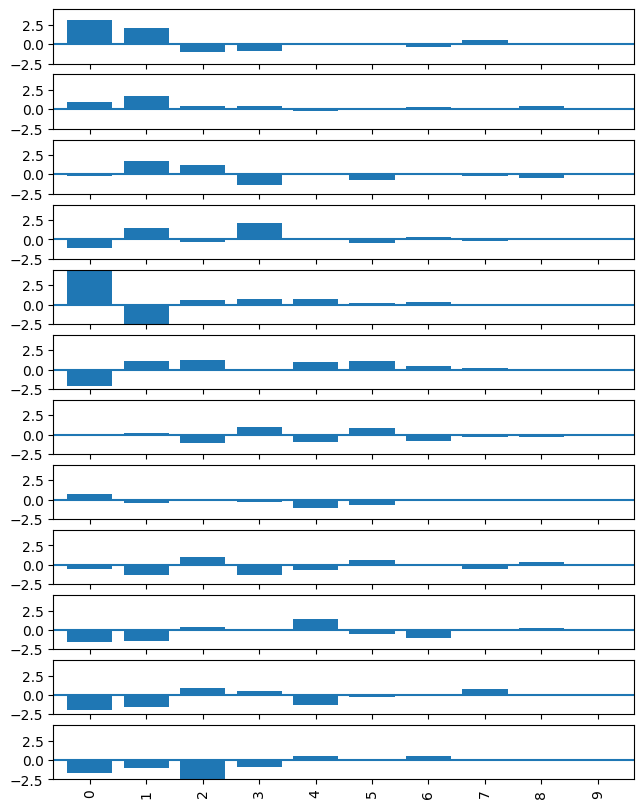

In [13]:
# 主成分分析の結果を確認 各選手の主成分得点を棒グラフで表示
f, axes = plt.subplots(len(score), 1, sharex=True, figsize=(7.5,10))
for i, ax in enumerate(axes):
    score.iloc[i, :].plot(ax=ax, kind='bar', width=0.8)
    ax.axhline(y=0)
    ax.set_ylim(-2.5, 4.5)

In [14]:
# 主成分分析の結果を確認 固有値を表示
pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(data))])

,0
PC1,4.092474
PC2,2.567566
PC3,1.644596
PC4,1.085935
PC5,0.715178
PC6,0.361820
PC7,0.238677
PC8,0.129794
PC9,0.070759
PC10,0.002293


In [15]:
# 主成分分析の結果を確認 固有ベクトルを表示
axes = pd.DataFrame(pca.components_, columns=data, 
                    index=["PC{}".format(x + 1) for x in range(len(data))])
axes.to_excel('ic_103_decathlon_pca_axes.xlsx', index=True, header=True)
axes

,100m,LongJump,ShotPut,HighJump,400m,110mH,DiscusThrow,PoleVault,JavelinThrow,1500m
PC1,0.315233,0.363230,-0.263787,0.420340,0.333500,0.461151,-0.218659,0.143574,0.041635,0.358304
PC2,-0.043490,0.123071,0.413696,0.291258,0.031176,0.177084,0.551629,0.213829,0.554085,-0.193981
PC3,-0.597660,-0.030691,-0.200154,0.060697,-0.292614,0.085947,0.050681,0.633560,-0.126344,0.291849
PC4,0.190096,-0.519760,0.159015,-0.068225,0.586073,0.024614,0.147668,0.430566,-0.329123,-0.064583
PC5,0.159911,-0.256970,0.553521,0.317851,-0.311001,-0.052148,-0.021899,-0.158407,-0.189471,0.583153
PC6,0.087094,0.663011,0.183447,-0.214209,0.165285,-0.436189,0.300992,0.145210,-0.317720,0.207568
PC7,-0.190126,-0.117672,0.047444,-0.288440,0.377117,-0.289690,-0.234600,-0.007799,0.600547,0.471874
PC8,-0.415129,0.240984,0.561131,-0.005431,0.209641,0.234428,-0.518468,-0.011517,-0.155874,-0.250107
PC9,-0.028609,-0.021531,-0.092544,0.651269,0.074511,-0.643802,-0.253909,0.143072,0.043273,-0.243225
PC10,0.512784,0.061841,0.167940,-0.275412,-0.378077,-0.040622,-0.379641,0.529185,0.208090,-0.130820


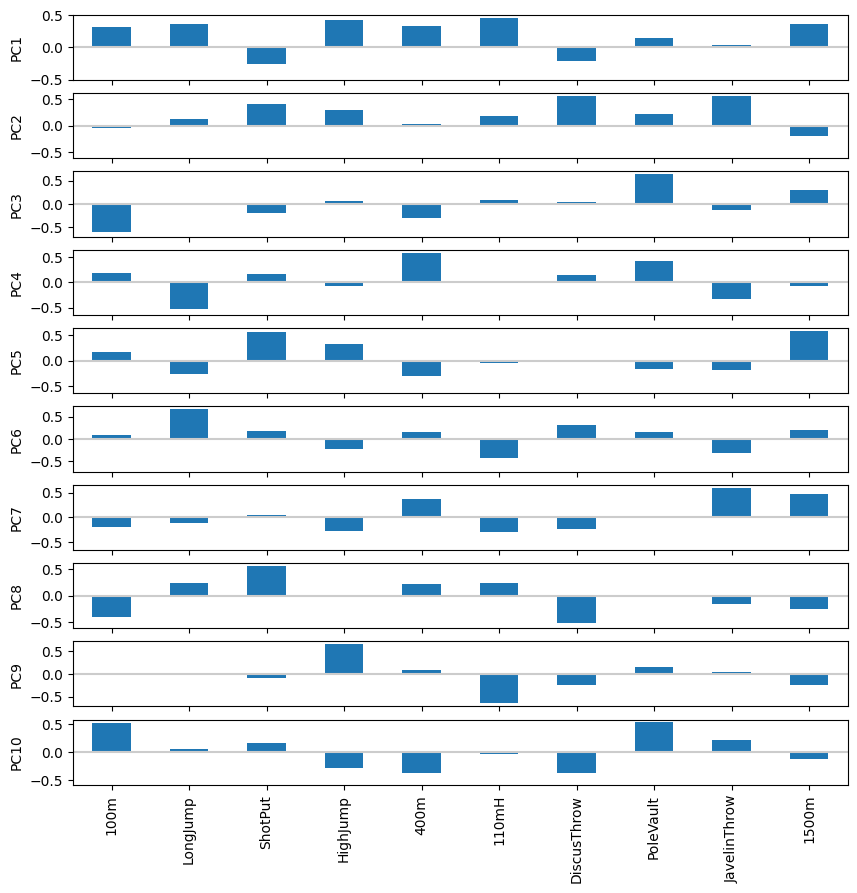

In [16]:
# 固有ベクトルを棒グラフで表示
centers = pd.DataFrame(pca.components_, columns=data)
f, axes = plt.subplots(len(data), 1, sharex=True, figsize=(10,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

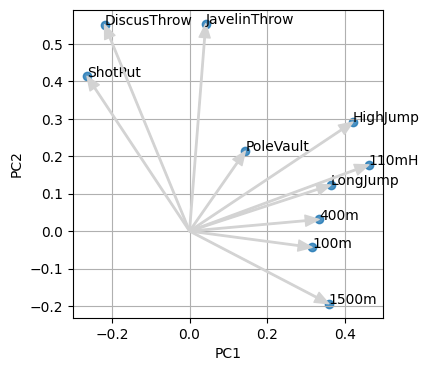

In [17]:
# 第一主成分と第二主成分における観測変数をプロット
plt.figure(figsize=(4, 4))
origin =(0,0)
for x, y, name in zip(pca.components_[0], pca.components_[1], data):
    plt.annotate(text='', xy=(x,y), xytext=origin, # text='' でエラーとなる場合は a='' に変更する
                 arrowprops=dict(shrink=0, width=1, headwidth=8, headlength=10, 
                 connectionstyle='arc3', facecolor='lightgray', edgecolor='lightgray'))
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

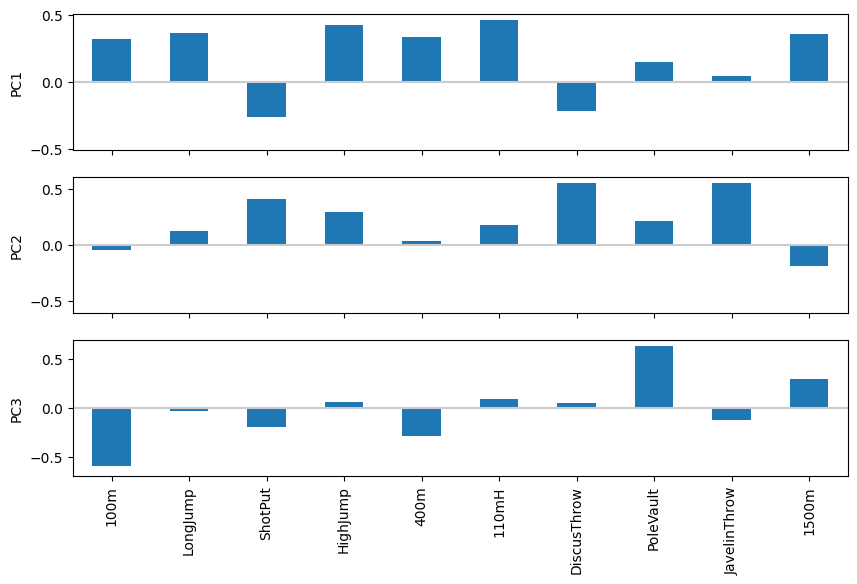

In [18]:
# 固有ベクトル(PC1-PC3)を棒グラフで表示
max_i = 3
centers = pd.DataFrame(pca.components_, columns=data)
f, axes = plt.subplots(max_i, 1, sharex=True, figsize=(10,6))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
    if i >= max_i:
        break

In [19]:
# 寄与率
_output = ''
for i in range(10):
    _output = _output + f'[PC{i+1} {pca.explained_variance_ratio_[i]:.03f}] '
print(_output)

[PC1 0.375] [PC2 0.235] [PC3 0.151] [PC4 0.100] [PC5 0.066] [PC6 0.033] [PC7 0.022] [PC8 0.012] [PC9 0.006] [PC10 0.000] 


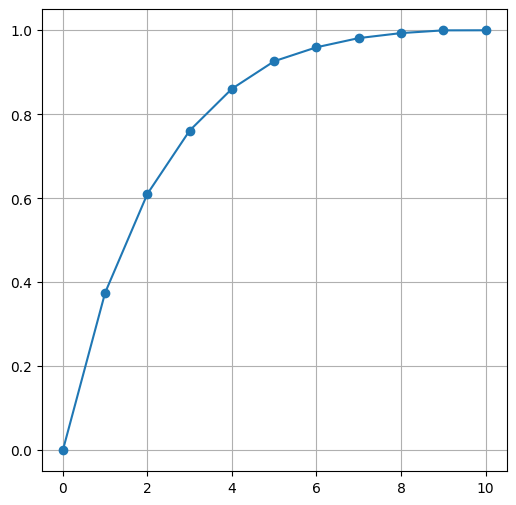

In [20]:
# 累積寄与率
plt.figure(figsize=(6, 6))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.grid()
plt.show()